## Exploratory Data Analysis Project


Data was sourced from openFDA - the US Food and Drug Administration (USFDA) API. We selected animal and veterinary API endpoints. The available API was the Adverse Event Report. We selected data on a small set of attributes of cats, recorded from 1987-2021. 

We obtained an API key, defined a base url, an made API calls. The output was converted to json format. The initial data retrieved had lots of missing data, so we decided to focus on specific breed. The key was not used for most of the data retrieval. Data extraction was facilitated by a loop.  The original 500 records were stored in a dataframe and also saved as a .csv file.

Our dataframe comprises reports of incidents where drug exposure resulted in adverse reactions in cats. After inspecting the variables, we trimmed the dataframe to a set of 238 records. We limited it to the five most abundant breed categories and 8 most abundant drugs. We identified the top three drugs reported to cause adverse reactions: Selamectin, Spinosad, and Fluralaner Spot-On Solution. We also explored associations between breed, gender, age, drug, and outcome. 


### Retrieving data and creating dataframe

In [1]:
#Setting dependencies

import numpy as np
import pandas as pd

import json
import requests
import time

import matplotlib.pyplot as plt
from pandas.plotting import table
from pprint import pprint
import seaborn as sns

# Import API key

from api_keys import api_key

In [2]:
# adding api_key to base url to obtain FDA information 
base_url = "https://api.fda.gov/drug/event.json?api_key=" + api_key

# changing the output to json 
req = requests.get(base_url)
data = req.json()

#print the data to show something is returned
#print(data)

In [3]:
#creating empty dictionary to store extracted data

cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}

#verifying search on Cat species and positioning on breed work correctly 

base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+animal.breed.breed_component='Domestic Shorthair'"
req = requests.get(base_url)
data = req.json()

#add 1 row to the cats_data dictionary with information extracted - limit for this api call is 1 result

cats_data['gender'].append(data['results'][0]['animal']['gender'])
cats_data['age'].append(data['results'][0]['animal']['age']['min'])
cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
cats_data['date_in'].append(data['results'][0]['original_receive_date'])

print(cats_data)

{'gender': ['Male'], 'age': ['10.00'], 'weight': ['6.350'], 'breed': ['Domestic Shorthair'], 'drug': ['Spinosad'], 'outcome': ['Recovered/Normal'], 'date_in': ['20170508']}


In [4]:
# This url returns only the first match, so we used a loop to skip entries and pick up another one.otherwise the 
# same one is returned every time.
# Returning 500 results runs for a bit of time

cats_data = {'gender':[],
                'age':[],
                'weight':[],
                'breed':[],
                'drug':[],
                'outcome':[],
                'date_in':[]}
base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')"

# NB: It turns out that the API key was unnecessary - the + api_key part of the call was not copied, and the call was successful. These data were extracted without using the key.

counter = 1
for i in range(500):
    req = requests.get(base_url)
    data = req.json()

    #validate the data, if age and weight don't exist, replace with 0. If outcome, gender, breed, and drug
    #don't exist, replace with 'Unknown'. If original_receive_date doesn't exist, replace with nan.
    try:
        cats_data['age'].append(data['results'][0]['animal']['age']['min'])
    except:
        cats_data['age'].append('0')
    
    try:
        cats_data['weight'].append(data['results'][0]['animal']['weight']['min'])
    except:
        cats_data['weight'].append('0')

    try:
        cats_data['outcome'].append(data['results'][0]['outcome'][0]['medical_status'])
    except:
        cats_data['outcome'].append('Unknown')
    
    try:
        cats_data['date_in'].append(data['results'][0]['original_receive_date'])
    except:
        cats_data['date_in'].append(np.nan)

    try:
        cats_data['gender'].append(data['results'][0]['animal']['gender'])
    except:
        cats_data['gender'].append('Unknown')
    
    try:
        cats_data['breed'].append(data['results'][0]['animal']['breed']['breed_component'])
    except:
        cats_data['breed'].append('Unknown')
    
    try:
        cats_data['drug'].append(data['results'][0]['drug'][0]['active_ingredients'][0]['name'])
    except:
        cats_data['drug'].append('Unknown')
          
    counter +=1
    #counter is converted to a string and used as a skip value for gathering random records
    str_count = str(counter)
    base_url = "https://api.fda.gov/animalandveterinary/event.json?search=animal.species=Cat+(animal.breed.breed_component='Domestic Shorthair'+OR+animal.breed.breed_component='Domestic Longhair')&skip=" + str_count
    

In [5]:
# converting the raw data in the cats dictionary to a dataframe and writing it out to a csv file

cat_df = pd.DataFrame.from_dict(cats_data)
cat_df.to_csv("cat_data.csv")

#print the info of the dataframe

cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gender   500 non-null    object
 1   age      500 non-null    object
 2   weight   500 non-null    object
 3   breed    500 non-null    object
 4   drug     500 non-null    object
 5   outcome  500 non-null    object
 6   date_in  499 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


#### Modifying datatypes for analysis

In [6]:
#converting the age and weight columns to numerics (floats)

cat_df[["age", "weight"]] = cat_df[["age", "weight"]].apply(pd.to_numeric)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gender   500 non-null    object 
 1   age      500 non-null    float64
 2   weight   500 non-null    float64
 3   breed    500 non-null    object 
 4   drug     500 non-null    object 
 5   outcome  500 non-null    object 
 6   date_in  499 non-null    object 
dtypes: float64(2), object(5)
memory usage: 27.5+ KB


In [7]:
# Extracting the year from the intake date

cat_df["date_in"] = pd.to_datetime(cat_df["date_in"])
cat_df["Year"] = cat_df['date_in'].dt.year

# Dropping intake date column

cat_df.drop('date_in', axis=1, inplace=True)
cat_df.head(15)

,gender,age,weight,breed,drug,outcome,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017.0
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017.0
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018.0
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019.0
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019.0
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019.0
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered/Normal,2019.0
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered/Normal,2021.0
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020.0
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Outcome Unknown,2021.0


In [8]:
# Renaming columns, including units when appropriate.

cat_df.columns = ['Gender', 'Age_y', 'Weight_kg', 'Breed', 'Drug', 'Status','Year']
cat_df.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered/Normal,2017.0
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017.0
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered/Normal,2018.0
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Outcome Unknown,2019.0
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019.0


### DATA FRAME WRANGLING

The goal is to minimize the influence of uninformative data in the dataframe. It's worth checking out the number of distinctive values for categorical variables. If there are too many, it can clutter visualiztions. Categories with a low abundance of records will be dropped to minimize noise in the display.

First, we'll work with eliminating ambiguity by selecting the most informative categories and records from the data set.

In [9]:
cat_df['Status'].value_counts()

Unknown                   169
Outcome Unknown           102
Recovered/Normal          101
Ongoing                    80
Died                       39
Recovered with Sequela      5
Euthanized                  4
Name: Status, dtype: int64

There doesn't seem to be a distinction between "Outcome Unknown" and "Unknown", so these are combined. We shortened the string for one category to improve readability.

In [10]:
cat_df['Status'].replace('Outcome Unknown','Unknown', inplace=True)

cat_df['Status'].replace('Recovered/Normal','Recovered', inplace=True)
cat_df.head(10)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017.0
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017.0
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018.0
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019.0
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019.0
5,Male,2.0,5.897,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2019.0
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019.0
7,Unknown,0.0,0.000,Cat (unknown),Imidacloprid,Recovered,2021.0
8,Male,9.0,4.309,Domestic Shorthair,Fluralaner Spot-On Solution,Ongoing,2020.0
9,Female,11.0,2.722,Cat (unknown),Imidacloprid,Unknown,2021.0


Checking the numerical variables to see the abundance of uninformatitve zeroes. Ages and weights of zero are meaningless and can distory the statistical properties of the data set. This can distort displays and can pave the way for drawing inaccurate conclusions. 

In [11]:
cat_df['Age_y'].value_counts()

0.00     70
6.00     48
3.00     42
2.00     37
5.00     36
8.00     32
4.00     27
7.00     22
10.00    22
9.00     22
12.00    20
11.00    17
1.00     16
15.00    15
13.00    14
14.00     8
16.00     8
3.50      7
1.50      5
17.00     5
10.50     4
18.00     4
7.50      3
4.50      3
12.50     2
19.00     1
6.50      1
50.00     1
5.11      1
11.50     1
20.00     1
2.20      1
2.50      1
5.30      1
4.20      1
26.00     1
Name: Age_y, dtype: int64

In [12]:
cat_df['Weight_kg'].value_counts()

0.000    79
4.990    19
4.536    17
4.540    16
5.440    14
         ..
4.350     1
6.668     1
3.490     1
6.033     1
1.410     1
Name: Weight_kg, Length: 177, dtype: int64

We see that 78 of the records have a weight of 0 kgs, and 69 have an age of 0 years. We will filter the data and create a new frame without those records. Thus, we'll restrict our attention to subjects estimated to be at least one year old, and one kg in weight.

In [13]:
# Inspecting breed category
cat_df['Breed'].value_counts();

There's a lot of ambiguity among the categories, and eleven categories had two or fewer records. Here, we trim the dataframe set to eliminate the latter group. Then, we re-code to combine "Cat (unknown)" with "Cat (other)" and "Mixed (Cat)".

In [14]:
cat_df['Breed'].replace('Cat (unknown)','Unknown', inplace=True)
cat_df['Breed'].replace('Cat (other)', 'Unknown', inplace=True)
cat_df['Breed'].replace('Mixed (Cat)', 'Unknown', inplace=True)
cat_df['Breed'].value_counts();

The next goal: create a dataframe that includes only the brteed categories for which the frequency exceeds 25. Several filtering methods fail and yield the same TypeError. The naive work-around is to extract smaller dataframes from this larger one and then concatenate them. Let's see if this works: 

In [15]:
dshort = cat_df[cat_df['Breed'] == 'Domestic Shorthair']
dshort.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
0,Male,10.0,6.350,Domestic Shorthair,Spinosad,Recovered,2017.0
1,Female,12.0,3.130,Domestic Shorthair,Cefovecin,Ongoing,2017.0
2,Male,1.0,4.309,Domestic Shorthair,Spinosad,Recovered,2018.0
3,Female,9.0,0.000,Domestic Shorthair,Imidacloprid,Unknown,2019.0
4,Male,5.0,6.577,Domestic Shorthair,Maropitant Citrate,Ongoing,2019.0


In [16]:
dlong = cat_df[cat_df['Breed'] == 'Domestic Longhair']
dlong.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
6,Male,8.0,8.845,Domestic Longhair,Spinosad,Recovered,2019.0
11,Male,8.0,4.540,Domestic Longhair,Spinosad,Recovered,2012.0
14,Male,7.0,5.400,Domestic Longhair,Pradofloxacin,Recovered,2013.0
35,Male,15.0,5.897,Domestic Longhair,Spinosad,Recovered,2015.0
69,Female,10.0,3.900,Domestic Longhair,Spinosad,Recovered with Sequela,2012.0


In [17]:
dmed = cat_df[cat_df['Breed'] == 'Domestic Mediumhair']
dmed.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
38,Female,3.0,6.396,Domestic Mediumhair,Spinosad,Recovered,2016.0
44,Male,6.0,7.484,Domestic Mediumhair,Fluralaner Spot-On Solution,Ongoing,2018.0
45,Female,0.0,0.000,Domestic Mediumhair,Selamectin,Ongoing,2018.0
49,Female,7.0,4.445,Domestic Mediumhair,Buprenorphine,Ongoing,2020.0
53,Male,6.0,5.440,Domestic Mediumhair,Spinosad,Recovered,2013.0


In [18]:
dunsp = cat_df[cat_df['Breed'] == 'Domestic (unspecified)']
dunsp.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
16,Male,2.0,6.35,Domestic (unspecified),Pyrantel Pamoate,Unknown,2007.0
17,Male,10.0,5.50,Domestic (unspecified),Enrofloxacin,Unknown,2006.0
20,Male,15.0,8.16,Domestic (unspecified),Cyclosporine,Unknown,2011.0
21,Female,17.0,3.18,Domestic (unspecified),Ketamine Hydrochloride,Unknown,2004.0
22,Male,2.0,4.99,Domestic (unspecified),Lufenuron,Unknown,1996.0


In [19]:
unkn = cat_df[cat_df['Breed'] == 'Unknown']
unkn.head(5)

,Gender,Age_y,Weight_kg,Breed,Drug,Status,Year
7,Unknown,0.0,0.000,Unknown,Imidacloprid,Recovered,2021.0
9,Female,11.0,2.722,Unknown,Imidacloprid,Unknown,2021.0
10,Unknown,0.0,0.000,Unknown,Praziquantel,Unknown,2021.0
12,Unknown,0.0,3.180,Unknown,Griseofulvin,Unknown,1996.0
18,Unknown,3.0,3.180,Unknown,Ketamine Hydrochloride,Unknown,1988.0


In [20]:
frames = [dshort, dlong, dmed, dunsp, unkn]

In [21]:
cat = pd.concat(frames)
#cat

Now we can drop the records with the uninformative zeroes from the dataframe. First, check the stats on the numerical variables before dropping:

In [22]:
cat['Age_y'].describe()

count    488.000000
mean       6.312111
std        5.203887
min        0.000000
25%        2.000000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

In [23]:
cat['Weight_kg'].describe()

count    488.000000
mean       3.921119
std        2.389825
min        0.000000
25%        2.585000
50%        4.263500
75%        5.440000
max       11.790000
Name: Weight_kg, dtype: float64

In [24]:
cat.drop(cat.index[cat['Age_y'] == 0], inplace = True)
cat['Age_y'].describe()

count    419.000000
mean       7.351575
std        4.887809
min        1.000000
25%        3.500000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

In [25]:
cat.drop(cat.index[cat['Weight_kg'] == 0], inplace = True)
cat['Weight_kg'].describe()

count    397.000000
mean       4.660836
std        1.852280
min        0.360000
25%        3.360000
50%        4.540000
75%        5.897000
max       11.790000
Name: Weight_kg, dtype: float64

We see that the means have changed: mean cat age has increased by one year; mean cat weight has increased by 0.7 kg. We see a reduction in standard deviation for both variables. Minimizing standard deviation improves precision.

At this point, we now have informative records for about 400 cats. Now, we can restrict the numbers of drugs to include in the plots. First, we check the frequency of drugs, and then filter out all of the records for which the abundance of a drug is >= 10

In [26]:
cat['Drug'].value_counts()

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Nitenpyram                     21
Imidacloprid                   18
                               ..
Amoxicillin                     1
Atipamezole                     1
Orbifloxacin                    1
Clindamycin Hydrochloride       1
Ivermectin                      1
Name: Drug, Length: 66, dtype: int64

In [27]:
catdf = cat.groupby('Drug').filter(lambda x: (x['Drug'].count()>=10).any())

In [28]:
catdf;

In [29]:
catdf['Drug'].value_counts()

Selamectin                     73
Spinosad                       59
Fluralaner Spot-On Solution    27
Nitenpyram                     21
Imidacloprid                   18
Meloxicam                      15
Praziquantel                   15
Lufenuron                      12
Name: Drug, dtype: int64

The dataframe now has 240 records and is focused on 8 drugs. The smallest category for the 'Drug' variable, Lufenuron (n=12), represents 5% of the data. That's probably too small for any category, but that will be the lower limit for this exercise.

Finally, we look at the "Gender" category:

In [30]:
catdf['Gender'].value_counts()

Male       137
Female      98
Unknown      4
Mixed        1
Name: Gender, dtype: int64

There are four categories, but we didn't drop "Unknown" and "Mixed" from the set. "Unknown" comes from lack of information, and "Mixed" may or may not be a hermaphrodite. 

Now, we can run the summary statistics on the numerical values:

In [31]:
catdf['Age_y'].describe()

count    240.000000
mean       6.963792
std        4.882630
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       50.000000
Name: Age_y, dtype: float64

That max cat age could be a problem. There are two instances of cats over the age of 25, those will be dropped. 

In [32]:
catdf.drop(catdf.index[catdf['Age_y'] >= 26], inplace = True)
catdf['Age_y'].describe()

count    239.000000
mean       6.783724
std        4.015680
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       19.000000
Name: Age_y, dtype: float64

In [33]:
catdf['Weight_kg'].describe()

count    239.000000
mean       4.812004
std        1.863792
min        0.360000
25%        3.629000
50%        4.580000
75%        5.900000
max       11.790000
Name: Weight_kg, dtype: float64

And summary proportions of nominal categorical variables:

In [34]:
catdf['Breed'].value_counts()/catdf['Breed'].value_counts().sum()

Domestic Shorthair        0.510460
Domestic (unspecified)    0.271967
Domestic Longhair         0.083682
Unknown                   0.071130
Domestic Mediumhair       0.062762
Name: Breed, dtype: float64

In [35]:
catdf['Gender'].value_counts()/catdf['Gender'].value_counts().sum()

Male       0.569038
Female     0.410042
Unknown    0.016736
Mixed      0.004184
Name: Gender, dtype: float64

In [36]:
catdf['Status'].value_counts()/catdf['Status'].value_counts().sum()

Unknown                   0.460251
Recovered                 0.301255
Ongoing                   0.163180
Died                      0.054393
Recovered with Sequela    0.012552
Euthanized                0.008368
Name: Status, dtype: float64

In [37]:
catdf['Drug'].value_counts()/catdf['Drug'].value_counts().sum()

Selamectin                     0.301255
Spinosad                       0.246862
Fluralaner Spot-On Solution    0.112971
Nitenpyram                     0.087866
Imidacloprid                   0.075314
Meloxicam                      0.062762
Praziquantel                   0.062762
Lufenuron                      0.050209
Name: Drug, dtype: float64

#### Categorical variables: visualizing proportions

With the exception of age and weight, the variables in this dataframe are nominal categorical ones. As such, we can't compute summary statistics such as mean or median, etc. We can capture the proportions of categories for each variable using a simple display. This sets the foundation for understanding more complicated displays. Since these variables are nominal, the best choice is a pie chart. We do this below:

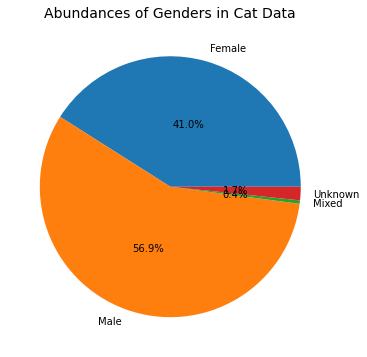

In [38]:
data1 = catdf.groupby('Gender').size()
pie, ax = plt.subplots(figsize=[10,6])
labels = data1.keys()
plt.pie(x=data1, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Abundances of Genders in Cat Data", fontsize=14);
pie.savefig("GenderPieChart.png")

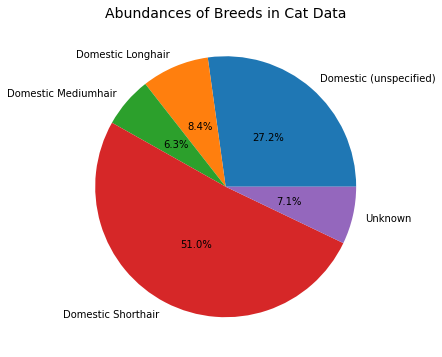

In [39]:
data2 = catdf.groupby('Breed').size()
pie, ax = plt.subplots(figsize=[10,6])
labels = data2.keys()
plt.pie(x=data2, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Abundances of Breeds in Cat Data", fontsize=14);
pie.savefig("BreedPieChart.png")

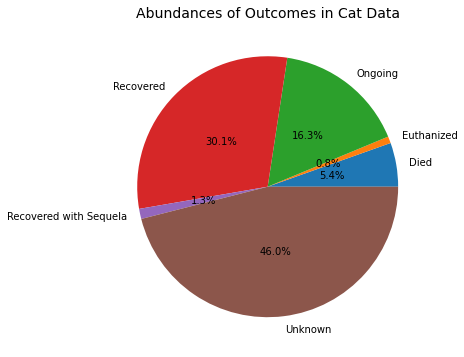

In [40]:
data3 = catdf.groupby('Status').size()
pie, ax = plt.subplots(figsize=[10,6])
labels = data3.keys()
plt.pie(x=data3, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Abundances of Outcomes in Cat Data", fontsize=14);
pie.savefig("StatusPieChart.png")

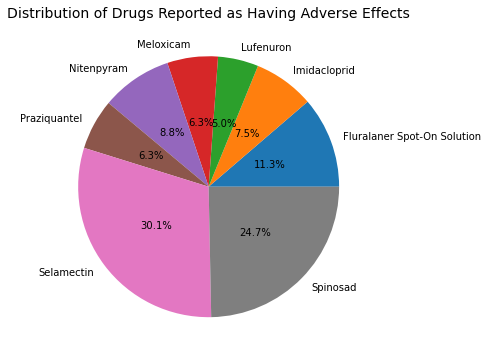

In [41]:
data4 = catdf.groupby('Drug').size()
pie, ax = plt.subplots(figsize=[10,6])
labels = data4.keys()
plt.pie(x=data4, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Distribution of Drugs Reported as Having Adverse Effects", fontsize=14);
pie.savefig("DrugPieChart.png")

In summary, in this data set, the gender split is nearly 60/40 male/female. There's not a whole lot of variety regarding breed. Domestic Shorthairs comprise at minimum half of the sample. The Domestic Medium and Longhair categories account for less than 15% of the data. The balance is largely unspecified, and quite possibly Domestic Shorthair. Regarding outcomes, forty-six percent were unknown, thirty percent had recovered, and about 5% had died. Finally, of the drugs reported, the three most abundant were Selamectin (30%), Spinosad (almost 25%) and Fluralaner Spot-On Solution (11%). 

### CREATING VISUALIZATIONS TO EXPLORE QUESTIONS

These data comprise reports of incidents where drug exposure resulted in adverse reactions in cats. We considered several questions:

### 1) What is the distribution of drug type among breeds? 

Here we are interested in the relationship between the medications, 'Drug', used and the adverse reactions, 'Status', reported. We are specifically concerned with the highest frequency cat breeds or breed effect, if there is a gender effect on outcome, and age correlation to death event.

We start by exploring what the highest frequency drugs(reported >10 times) and highest frequency cat breeds are. This was isolated in the above code using a series of groupyby, limit specifications, and concatenating. We see that Domestic breeds (long, short unk) are most often reported with reactions. Other insights include... 

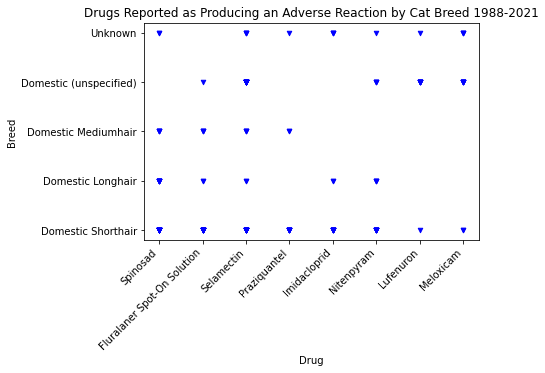

In [42]:
#create scatter plot
catdf.plot(kind='scatter', y='Breed', x='Drug', color="blue", marker="v")
#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final.png") 
#show plot
plt.show()

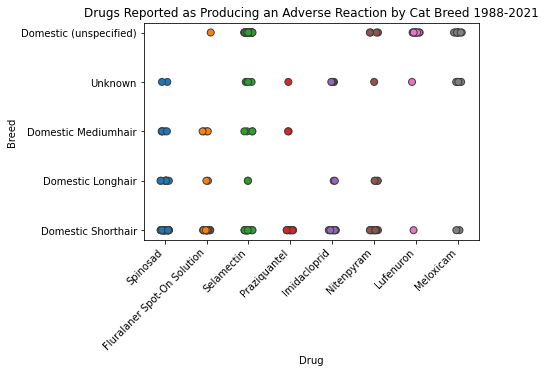

In [43]:
#does work for this data as it overlaps
#plt.figure(figsize = (8,3))
#create swarmplot plot
sns.stripplot(data=catdf, y='Breed', x='Drug', alpha=1.0, s=7, linewidth=1.0)

#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final3.png") 
#show plot
plt.show()

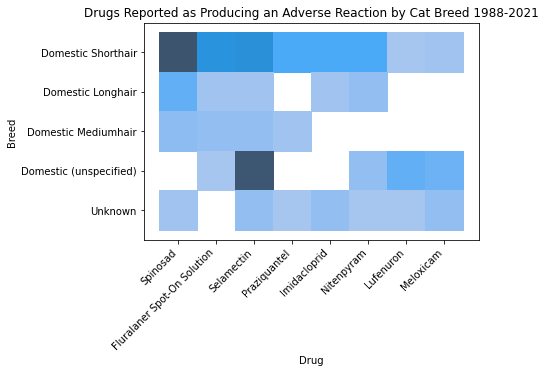

In [44]:
#same data in hist form

#create histogram plot
sns.histplot(data=catdf, y='Breed', x='Drug')
#create labels & display the title
plt.title("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Drugs Reported as Producing an Adverse Reaction by Cat Breed 1988-2021 final2.png") 
#show plot
plt.show()

##2) What is the distibution of drugs whose reaction concludes in death?

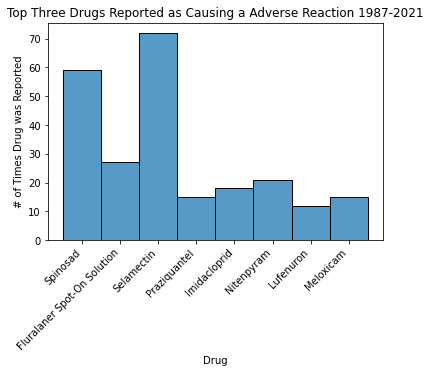

In [45]:
# drug disto
drugs=catdf['Drug']
#create plot
fig, ax = plt.subplots()
sns.histplot(drugs, bins=10)
#tick marks
#ax.tick_params('y', colors="green")
#labels
plt.xlabel("Drug")
plt.ylabel("# of Times Drug was Reported")
plt.title("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021")
#change size so labels fit
plt.xticks(rotation=45, ha='right')
plt.savefig("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021 hist final.png") 
plt.show()

Isolated the top three highest frequency drugs with in the distribution of drugs realted to death outcome

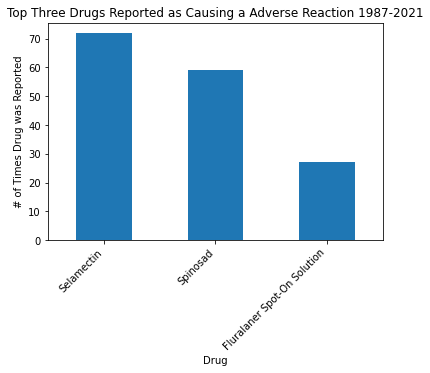

In [46]:
# Top 3 drugs resulting in death 
d3=catdf['Drug'].value_counts()[:3]
#create plot
fig, ax = plt.subplots()
#plots df "go-" creates a green line with circles
d3.plot(kind="bar")
#labels
plt.xlabel("Drug")
plt.ylabel("# of Times Drug was Reported")
plt.title("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021")
plt.xticks(rotation=45, ha='right')
#saving file
#plt.savefig("Top Three Drugs Reported as Causing a Adverse Reaction 1987-2021 bar final.png") 
plt.show()

Isolating a specific status of death and further looked at the drug; Selamectin, with the most reports of death 

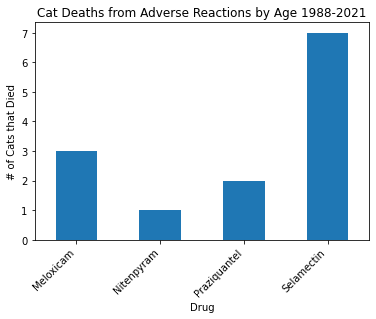

In [47]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Died']
#count deaths by age and sort order
h=g["Drug"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="Age_y")
#create labels 
plt.xlabel("Drug")
plt.ylabel('# of Cats that Died' )
 
# display the title
plt.title("Cat Deaths from Adverse Reactions by Age 1988-2021")
#rotate axis label          
plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Number of Cat Deaths from Adverse Reactions by Age 1988-2021 final.png") 
#show plot
plt.show()

### 3) What is the relationship between age and death?

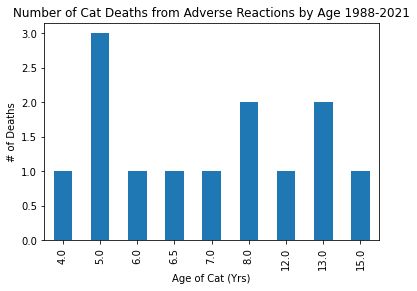

In [48]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Died']
#count deaths by age and sort order
h=g["Age_y"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="Age_y", )
#create labels 
plt.xlabel('Age of Cat (Yrs)')
plt.ylabel('# of Deaths')
 
# display the title
plt.title("Number of Cat Deaths from Adverse Reactions by Age 1988-2021")
#plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Number of Cat Deaths by Age 1988-2021 Final.png") 
#show plot
plt.show()

## 4) Distribution of Age and Gender of Cats 

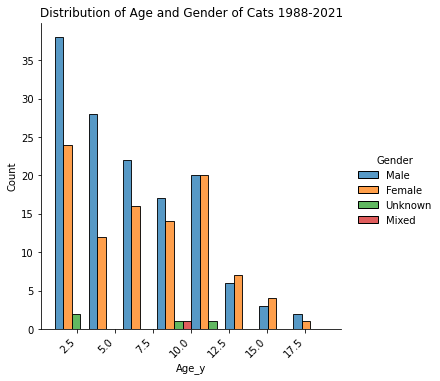

In [49]:
#create histogram plot
#sns.scatterplot(data=catdf, y='Gender', x='Breed' )
sns.displot(catdf, x="Age_y", hue="Gender", multiple="dodge", bins=8)
#create labels & display the title
plt.title("Distribution of Age and Gender of Cats 1988-2021")
#Rotate axis text
plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Distribution of Age and Gender of Cats 1988-2021final.png") 
#show plot
plt.show()

### 3) Facet plot: relationships among breed, gender, drug,  and outcome

Does gender have any importance in this data if so what affects does gender have? Also, is there an age affect taking place? More female cats are reported as having reactions. There is a rare occurance of hermaphoditic cats in the population data. 

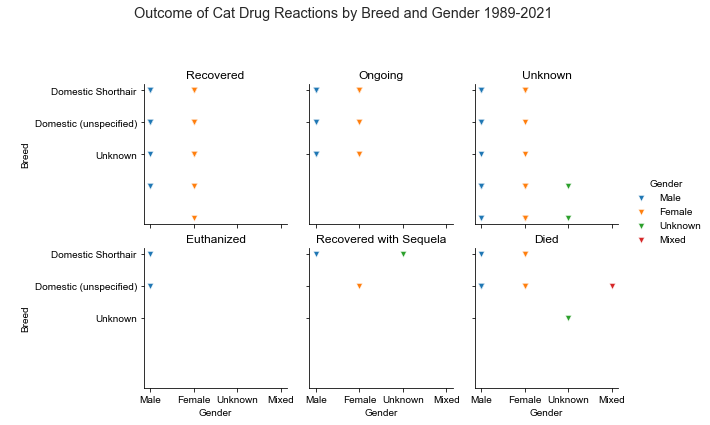

In [50]:
#Facet plots to look at outcomes, age, breed and gender effects/relationship
#organize the data in the grids
l = sns.FacetGrid(catdf, col="Status", hue="Gender", col_wrap=3)
#create plots
l.map(sns.scatterplot, "Gender", "Breed", marker='v')
#add gender legend
l.add_legend()
sns.set(style = 'whitegrid')
#enlarge plots
plt.subplots_adjust(top=0.8)
l.set_titles("{col_name}")
#title for grids
l.fig.suptitle('Outcome of Cat Drug Reactions by Breed and Gender 1989-2021')
#plt.savefig("Outcome of Cat Drug Reactions by Breed and Gender 1989-2021 Final.png") 
#show plot
#plt.tight_layout()  
plt.show()

Additional Facet plot: relationships among breed, outcome and drug

<ipython-input-51-73e28225ba60>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


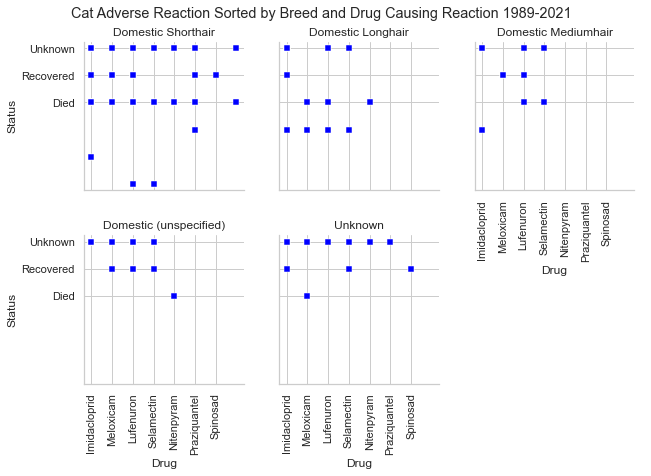

In [51]:
#Facet plots to look at outcomes, age, breed and gender effects/relationship
#organize the data in the grids
z = sns.FacetGrid(catdf, col="Breed", col_wrap=3)
#create plots
z.map(sns.scatterplot, "Drug", "Status", marker="s", color="blue")
#add gender legend
z.add_legend()
#enlarge plots
#plt.subplots_adjust(top=1.1)
for axes in z.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#plt.tight_layout()     
#plt.xticks(rotation=90, ha='right')
z.set_titles("{col_name}")
#title for grids
z.fig.suptitle('Cat Adverse Reaction Sorted by Breed and Drug Causing Reaction 1989-2021')
#move plots down to fit title
plt.subplots_adjust(top=0.9)
#plt.savefig("Cat Adverse Reaction Sorted by Breed and Drug Causing Reaction 1989-2021 Final.png") 
plt.show()

### 5) What is the relationship between age and the outcome of having recovered?

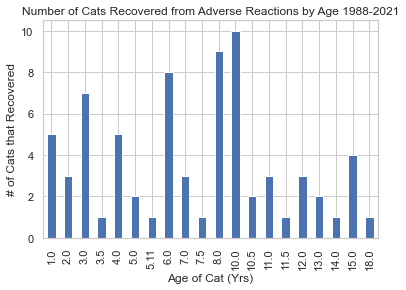

In [52]:
#sort data by deaths 
g=catdf[catdf["Status"] == 'Recovered']
#count deaths by age and sort order
h=g["Age_y"].value_counts().sort_index()
#h
#create bar graph
h.plot(kind="bar", x="age")
#create labels 
plt.xlabel('Age of Cat (Yrs)')
plt.ylabel('# of Cats that Recovered')
 
# display the title
plt.title("Number of Cats Recovered from Adverse Reactions by Age 1988-2021")
#plt.xticks(rotation=45, ha='right')
#save image
#plt.savefig("Number of Cats Recovered from Adverse Reactions by Age 1988-2021.png") 
#show plot
plt.show()

### 5) How was reaction to selamectin distributed across breed categories?

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Domestic (unspecified)'),
  Text(1, 0, 'Domestic Shorthair'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Domestic Mediumhair'),
  Text(4, 0, 'Domestic Longhair')])

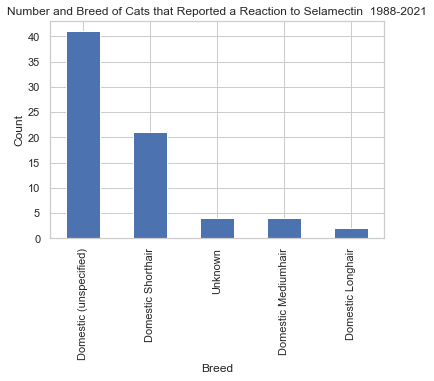

In [53]:
#sort data by deaths 
d=catdf[catdf["Drug"] == 'Selamectin']
q=catdf[catdf["Breed"] == 'Domestic Shorthair']
#count deaths by age and sort order
m=d["Breed"].value_counts()
#h
#create bar graph
m.plot(kind="bar", x="Breed")
#create labels 
plt.xlabel('Breed')
plt.ylabel('Count' )
# display the title
plt.title("Number and Breed of Cats that Reported a Reaction to Selamectin  1988-2021")
plt.xticks(rotation=90)
#plt.savefig("Number and Breed of Cats that Reported a Reaction to Selamectin  1988-2021.png") 
#show plot
#plt.show()

Distribution of all data in set -- not used for presentation as we did not take interest in exploring relations to weight 

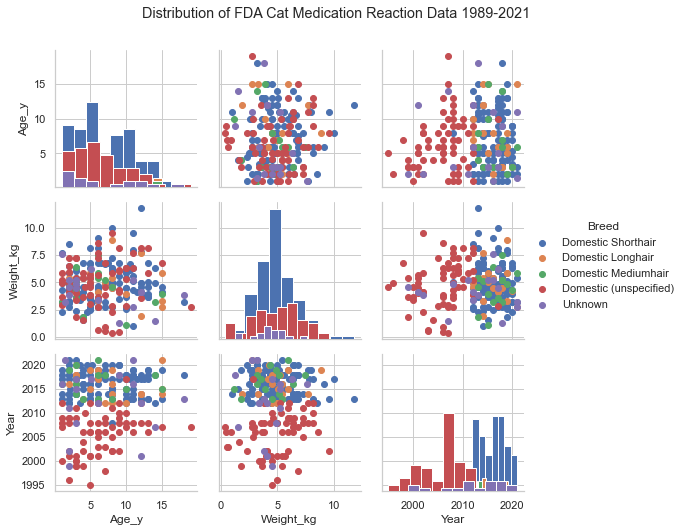

In [54]:
breeds = sns.PairGrid(catdf, hue="Breed").map_diag(plt.hist)
breeds.map_offdiag(plt.scatter)
breeds.add_legend()
breeds.fig.suptitle('Distribution of FDA Cat Medication Reaction Data 1989-2021')
plt.subplots_adjust(top=0.9)
#plt.savefig("Distro of data Final.png") 
plt.show()